# Ungraded Lab: Denoising with a CNN Autoencoder

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow-Advanced_Techniques_Specialization/blob/master/Generative_Deep_Learning_with_TensorFlow/Week2/Labs/C4_W2_Lab_5_FashionMNIST_NoisyCNNAutoEncoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In the final lab for this week, you will introduce noise to the Fashion MNIST dataset and train an autoencoder to reconstruct the original input images.

## Imports

In [1]:
import tensorflow as tf
from keras import layers, Model, optimizers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

2024-09-12 16:23:09.150902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 16:23:09.162975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 16:23:09.166837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 16:23:09.175307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare the Dataset

You will prepare the train and test sets a little differently this time. Instead of just normalizing the images, you will also introduce random noise and the generated images will be used as input to your model. The target or label will still be the clean images.

In [2]:
def map_image_with_noise(image, label):
    '''Normalizes the images and generates noisy inputs.'''
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0

    noise_factor = 0.5
    factor = noise_factor * tf.random.normal(shape=image.shape)
    image_noisy = image + factor
    image_noisy = tf.clip_by_value(image_noisy, 0.0, 1.0)

    return image_noisy, image

In [3]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image_with_noise)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image_with_noise)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

2024-09-12 16:23:11.457607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1898 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


## Build the Model

You will use the same model from the previous lab.

<img src="./images/AutoEncoder.png" width="75%" height="75%"/>

In [4]:
def encoder(inputs):
    '''Defines the encoder with two Conv2D and max pooling layers.'''
    conv_1 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    max_pool_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_1)

    conv_2 = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(max_pool_1)
    max_pool_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_2)

    return max_pool_2

In [5]:
def bottle_neck(inputs):
    '''Defines the bottleneck.'''
    bottle_neck = layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    encoder_visualization = layers.Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(bottle_neck)

    return bottle_neck, encoder_visualization

In [6]:
def decoder(inputs):
    '''Defines the decoder path to upsample back to the original image size.'''
    conv_1 = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    up_sample_1 = layers.UpSampling2D(size=(2, 2))(conv_1)

    conv_2 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(up_sample_1)
    up_sample_2 = layers.UpSampling2D(size=(2, 2))(conv_2)

    conv_3 = layers.Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(up_sample_2)

    return conv_3

In [7]:
def convolutional_auto_encoder():
    '''Builds the entire autoencoder model.'''
    inputs = layers.Input(shape=(28, 28, 1,))
    encoder_output = encoder(inputs)
    bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
    decoder_output = decoder(bottleneck_output)

    model = Model(inputs =inputs, outputs=decoder_output)
    encoder_model = Model(inputs=inputs, outputs=encoder_visualization)

    return model, encoder_model

In [8]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,073 (2.82 MB)

 Trainable params: 739,073 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train the Model

In [9]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=40)

Epoch 1/40


I0000 00:00:1726179793.623317   82618 service.cc:146] XLA service 0x72763400efa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726179793.623345   82618 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-09-12 16:23:13.668785: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-12 16:23:13.828537: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90201


  7/468 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.6560 

I0000 00:00:1726179797.715453   82618 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.3629 - val_loss: 0.3004
Epoch 2/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.2966 - val_loss: 0.2943
Epoch 3/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2909 - val_loss: 0.2911
Epoch 4/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2884 - val_loss: 0.2891
Epoch 5/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2863 - val_loss: 0.2872
Epoch 6/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2845 - val_loss: 0.2862
Epoch 7/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2839 - val_loss: 0.2854
Epoch 8/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2829 - val_loss: 0.2848
Epoch 9/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2823 - val_loss: 0.2842
Epoch 10/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2821 - val_loss: 0.2839
Epoch 11/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2811 - val_loss: 0.2833
Epoch 12/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 

## Display sample results

Let's see if the model can generate the clean image from noisy inputs.

In [10]:
def display_one_row(disp_images, offset, shape=(28, 28)):
    '''Display sample outputs in one row.'''
    for idx, noisy_image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        noisy_image = np.reshape(noisy_image, shape)
        plt.imshow(noisy_image, cmap='gray')

def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8, 4)):
    '''Displays the input, encoded, and decoded output values.'''
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(28, 28,))
    display_one_row(disp_encoded, 10, shape=enc_shape)
    display_one_row(disp_predicted, 20, shape=(28, 28,))

2024-09-12 16:32:10.575095: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


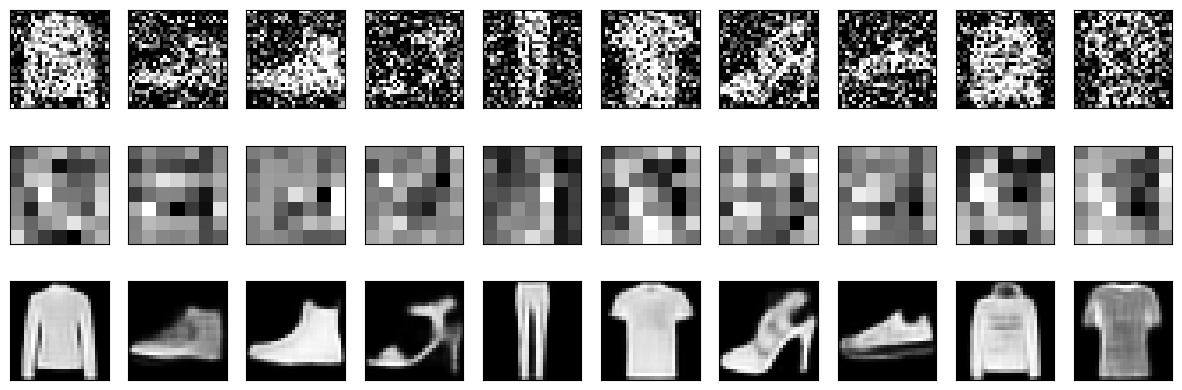

In [11]:
# Take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# Take the input images and put them in a list
output_samples = []

for input_image, image in tfds.as_numpy(test_dataset):
    output_samples = input_image

# Pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# Get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# Get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# Display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7, 7))